In [ ]:
# %%
# https://nsidc.org/data/smap_l1_l3_anc_static/versions/1
import numpy as np
import xarray as xr
import netCDF4
import matplotlib.pyplot as plt
import numpy.ma as ma
import pandas as pd
import os
from datetime import datetime
import glob
from tqdm import tqdm
# %% [markdown]
# # Process PET data

# %% [markdown]
# ## Read SMAP L4 data
from rasterio.enums import Resampling

In [2]:
# %% [markdown]
# # Configuration

# %%
data_dir = r"/home/waves/projects/smap-drydown/data"
SMAPL3_dir = "SPL3SMP"
datarods_dir = "datarods"
SMAPL4_dir = "SPL4SMGP"
SMAPL4_grid_dir = "SMAPL4SMGP_EASEreference"
PET_dir = "PET"
SMAPL3_grid_sample = os.path.join(data_dir, r"SPL3SMP/SMAP_L3_SM_P_20150331_R18290_001.h5")

# %% [markdown]
# # Investigate netCDF4 file

# %%
ncf = netCDF4.Dataset(SMAPL3_grid_sample, diskless=True, persist=False)
nch_am = ncf.groups.get('Soil_Moisture_Retrieval_Data_AM')
nch_pm = ncf.groups.get('Soil_Moisture_Retrieval_Data_PM')

# %%
nch_am.variables

# %%
nch_pm.variables

# %% [markdown]
# # Prepare geocoordinate matrix 

# %%
# Return as regular numpy array rather than masked array
_latitude = ma.getdata(nch_am.variables['latitude'][:].filled(fill_value=np.nan), subok=True)
_longitude = ma.getdata(nch_am.variables['longitude'][:].filled(fill_value=np.nan), subok=True)
_EASE_column_index = ma.getdata(nch_am.variables['EASE_column_index'][:].astype(int).filled(fill_value=-1), subok=True)
_EASE_row_index = ma.getdata(nch_am.variables['EASE_row_index'][:].astype(int).filled(fill_value=-1), subok=True)

# %%
# Coordinates with no data are skipped --- fill them
latitude = np.nanmax(_latitude, axis=1)
EASE_row_index = np.nanmax(_EASE_row_index, axis=1)
longitude = np.nanmax(_longitude, axis=0)
EASE_column_index = np.nanmax(_EASE_column_index, axis=0)

# %%
coord_info_column = pd.DataFrame({"latitude":latitude, "EASE_column_index":EASE_row_index})
coord_info_row = pd.DataFrame({"longitude":longitude, "EASE_row_index":EASE_column_index})
coord_info = coord_info_row.assign(key=1).merge(coord_info_column.assign(key=1), on='key').drop('key', axis=1)
coord_info.index.name = 'id'
# %%
# Get a list of files 
SMAPL3_fn_pattern = f'SMAP_L3_SM_P_*.h5'
SMAPL3_file_paths = glob.glob(rf'{data_dir}/{SMAPL3_dir}/{SMAPL3_fn_pattern}')
print(f"{SMAPL3_fn_pattern}: {len(SMAPL3_file_paths)} ... {len(SMAPL3_file_paths)/365:.1f} yrs of data available")

# %%
_ds_SMAPL3 = xr.open_dataset(SMAPL3_file_paths[0], engine='rasterio', group='Soil_Moisture_Retrieval_Data_AM', variable=['soil_moisture'])
ds_SMAPL3_coord_template = _ds_SMAPL3.assign_coords({'x':longitude, 'y':latitude}).rio.write_crs("epsg:4326")
ds_SMAPL3_coord_template

SMAP_L3_SM_P_*.h5: 2675 ... 7.3 yrs of data available


<xarray.Dataset>
Dimensions:                                        (band: 1, y: 406, x: 964)
Coordinates:
  * band                                           (band) int64 1
  * x                                              (x) float32 -179.8 ... 179.8
  * y                                              (y) float32 83.63 ... -83.63
    spatial_ref                                    int64 0
Data variables:
    Soil_Moisture_Retrieval_Data_AM_soil_moisture  (band, y, x) float32 ...
Attributes: (12/698)
    Metadata_AcquisitionInformation_platformDocument_edition:                ...
    Metadata_AcquisitionInformation_platformDocument_publicationDate:        ...
    Metadata_AcquisitionInformation_platformDocument_title:                  ...
    Metadata_AcquisitionInformation_platform_antennaRotationRate:            ...
    Metadata_AcquisitionInformation_platform_description:                    ...
    Metadata_AcquisitionInformation_platform_identifier:                     ...
    ...                                                                          ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_coordinates: ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_long_name:   ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_units:       ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_valid_max:   ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_valid_min:   ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm__FillValue:  ...

In [3]:
# %%
# pet_chunks = {'x': 1200, 'y': 1200, 'time':1, 'band':1}
PET_fn_pattern = f'*_daily_pet.nc'
PET_file_paths = glob.glob(rf'{data_dir}/{PET_dir}/{PET_fn_pattern}')
print(f"{PET_fn_pattern}: {len(PET_file_paths)} ... {len(PET_file_paths):.1f} yrs of data available")
PET_file_paths

*_daily_pet.nc: 7 ... 7.0 yrs of data available


['/home/waves/projects/smap-drydown/data/PET/2018_daily_pet.nc',
 '/home/waves/projects/smap-drydown/data/PET/2019_daily_pet.nc',
 '/home/waves/projects/smap-drydown/data/PET/2015_daily_pet.nc',
 '/home/waves/projects/smap-drydown/data/PET/2016_daily_pet.nc',
 '/home/waves/projects/smap-drydown/data/PET/2017_daily_pet.nc',
 '/home/waves/projects/smap-drydown/data/PET/2021_daily_pet.nc',
 '/home/waves/projects/smap-drydown/data/PET/2020_daily_pet.nc']

In [4]:
print(f"Start reading dataset")
# # Get a list of files 
# # Load dataset
for filename in tqdm(PET_file_paths):
    try:
        _ds_PET = xr.open_dataset(filename)

        # The dataset is huge, resample before stacking
        _ds_PET = _ds_PET.rename({'longitude':'x', 'latitude':'y'})
        _ds_PET.rio.write_crs('epsg:4326', inplace=True)
        _ds_PET_resampled = _ds_PET.pet.interp_like(ds_SMAPL3_coord_template, method='linear', kwargs={'fill_value': np.nan})
        if 'ds_PET' in locals():
            ds_PET = xr.concat([ds_PET, _ds_PET_resampled], dim="time")
        else:
            ds_PET = _ds_PET_resampled
    except Exception as e:
        print(f"An error occurred: {e}")
        continue
        
print(f"End reading dataset")

Start reading dataset


100%|██████████| 7/7 [11:34<00:00, 99.19s/it] 

End reading dataset


In [5]:
ds_PET = ds_PET.sortby('time')
ds_PET

<xarray.DataArray 'pet' (time: 2557, y: 406, x: 964)>
array([[[9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        ...,
        [3.22641760e-01, 3.23801130e-01, 3.24948907e-01, ...,
         3.22344959e-01, 3.22071433e-01, 3.22166711e-01],
        [3.30436707e-01, 3.31035167e-01, 3.31936598e-01, ...,
         3.28489274e-01, 3.29012513e-01, 3.29498738e-01],
        [3.53748858e-01, 3.54741633e-01, 3.55982691e-01, ...,
         3.52822274e-01, 3.53345513e-01, 3.53774339e-01]],

       [[9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
...
        [2.26240143e-01, 2.22899571e-01, 2.20504969e-01, ...,
         2.22552329e-01, 2.24683702e-01, 2.26628587e-01],
        [9.45172682e-02, 9.26136151e-02, 9.06599909e-02, ...,
         1.10184066e-01, 1.04184180e-01, 9.82804224e-02],
        [5.20224512e-01, 5.43104827e-01, 5.69020033e-01, ...,
         4.85122055e-01, 4.96096969e-01, 5.07191062e-01]],

       [[9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        [9.96920997e+36, 9.96920997e+36, 9.96920997e+36, ...,
         9.96920997e+36, 9.96920997e+36, 9.96920997e+36],
        ...,
        [2.54606038e-01, 2.52413481e-01, 2.49690101e-01, ...,
         2.61772096e-01, 2.60221690e-01, 2.57157147e-01],
        [1.95593610e-01, 1.84092164e-01, 1.72622785e-01, ...,
         2.34844759e-01, 2.20952645e-01, 2.07754388e-01],
        [6.58622503e-01, 6.79145873e-01, 7.03226447e-01, ...,
         6.19385183e-01, 6.32785618e-01, 6.45771205e-01]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2021-12-31
    spatial_ref  int64 0
  * y            (y) float32 83.63 81.48 79.77 78.3 ... -79.77 -81.48 -83.63
  * x            (x) float32 -179.8 -179.4 -179.1 -178.7 ... 179.1 179.4 179.8

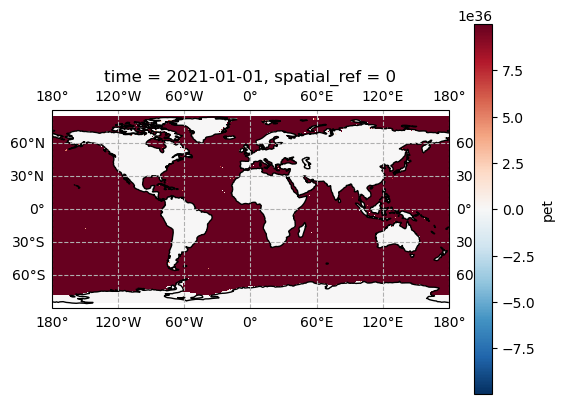

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a figure and axis with a specified projection (e.g., PlateCarree)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines to the map
ax.add_feature(cfeature.COASTLINE)

# Customize the plot (e.g., add gridlines, set extent)
ax.gridlines(draw_labels=True, linestyle='--')

# Set the map extent (you can customize these coordinates)
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

ds_PET.sel(time="2021-01-01").plot(ax=ax)

In [7]:
ds_PET.isel(x=0, y=0).to_dataframe().drop(['spatial_ref'], axis=1)

,y,x,pet
time,,,
2015-01-01,83.631973,-179.813278,9.969210e+36
2015-01-02,83.631973,-179.813278,9.969210e+36
2015-01-03,83.631973,-179.813278,9.969210e+36
2015-01-04,83.631973,-179.813278,9.969210e+36
2015-01-05,83.631973,-179.813278,9.969210e+36
...,...,...,...
2021-12-27,83.631973,-179.813278,9.969210e+36
2021-12-28,83.631973,-179.813278,9.969210e+36
2021-12-29,83.631973,-179.813278,9.969210e+36


In [ ]:

# Create and save the datarods  
out_dir = os.path.join(data_dir, datarods_dir, PET_dir)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    print(f"created {out_dir}")

from itertools import product
print("CREATING PET DATARODS")
for y_i, x_j in tqdm(product(EASE_row_index, EASE_column_index)):
    try:
        df_PET = ds_PET.isel(x=x_j, y=y_i).to_dataframe().drop(['spatial_ref'], axis=1)
        filename = f'{PET_dir}_{y_i:03}_{x_j:03}.csv'
        df_PET.to_csv(os.path.join(out_dir, filename))
    except Exception as e:
        print(f"An error occurred: {e}")
        continue

CREATING PET DATARODS


100327it [13:48:26,  1.73it/s]